# Sparkify Project 

## Project Defention
### Overview and Problem Statement
In this project, I followed these process:

- Data exploration to know more about data features and stats.
- Define Churn and label data based on churn definition
- Apply some feature engineering to apply some innovation and customizations on the generated model.
- Data transformation and splitting
- Model training, refinement and Evaluation

to analyze Sparkify(virtual music streaming service) data, in the way to achive the goal of project which is predicting which group of users are expected to churn - either downgrading from premium to free or cancel thier subscriptions altogether in the future to take decision based on it, by sending offers or trying to make them still with our service.

### Metrics
The used metric will be **F1-score** which is more helpful and takes both false positives and false negatives into account, and F1 is usually more useful than accuracy, especially if you have an uneven class distribution 

#### Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [2]:
# import libraries
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
from time import time
#pyspark imports
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf,when,col,avg,lit
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.classification import LogisticRegression, GBTClassifier,DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [3]:
# create a Spark session
spark = SparkSession.builder.appName("Predicting churn using Pyspark ML").getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

- Data Loading and cleaning can be done through these steps:
    - Loading Dataset
    - Learn about the data by: e.g checking data columns
    - Checking null values then resolve them (specially in IDs fields)
    - Checking datetime columns and format them if needed.

### Loading Dataset

In [4]:
#loading mini dataset to work with
dataset=spark.read.json("mini_sparkify_event_data.json")
dataset.toPandas().sample(3).T

,215987,138569,43406
artist,Steve Miller,None,Guns N' Roses
auth,Logged In,Logged In,Logged In
firstName,Angel,Andrew,Alexi
gender,M,M,F
itemInSession,60,240,173
lastName,Jacobs,Poole,Warren
length,66.2199,NaN,184.032
level,free,paid,paid
location,"Spokane-Spokane Valley, WA","Greensboro-High Point, NC","Spokane-Spokane Valley, WA"
method,PUT,PUT,PUT


### Learn about the data

In [5]:
#printing the column details
dataset.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



### Checking null values then resolve them

In [6]:
# Checking null values
dataset.toPandas().isna().mean()

artist           0.203812
auth             0.000000
firstName        0.029131
gender           0.029131
itemInSession    0.000000
lastName         0.029131
length           0.203812
level            0.000000
location         0.029131
method           0.000000
page             0.000000
registration     0.029131
sessionId        0.000000
song             0.203812
status           0.000000
ts               0.000000
userAgent        0.029131
userId           0.000000
dtype: float64

As shown IDs fields ```[sessionId,userId]``` havn't any null value but we can check if they are empty strings

In [7]:
print('# Users with ID "" :',dataset.filter(dataset['userId'] == '').count())
#Drop those users
dataset=dataset.filter(dataset['userId'] != '')
print('# Users with ID "" :',dataset.filter(dataset['userId'] == '').count())

# Users with ID "" : 8346
# Users with ID "" : 0


In [8]:
print('# Sessions with ID "" :',dataset.filter(dataset['sessionId'] == '').count())

# Sessions with ID "" : 0


### Checking datetime columns and format them

In [9]:
ts_convert_udf = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))
dataset = dataset.withColumn('event_time', ts_convert_udf('ts'))
dataset = dataset.withColumn('registration_time', ts_convert_udf('registration'))
get_hour_udf=udf(lambda x : datetime.datetime.fromtimestamp(x/ 1000.0).hour)
dataset = dataset.withColumn('event_hour',get_hour_udf('ts'))

In [10]:
dataset.head(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', event_time='2018-10-01 00:01:57', registration_time='2018-09-28 22:22:42', event_hour='0'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', event_time='2018-10-01 00:03:00', registration_time='2018-09-30 18

In [11]:
#Page column contains useful information about the user's activity
dataset.select('page').distinct().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [12]:
dataset.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [13]:
#filter the dataframe with Cancellation events
pd.DataFrame(dataset.filter("page == 'Cancellation Confirmation'").take(5), columns = dataset.columns)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,registration,sessionId,song,status,ts,userAgent,userId,event_time,registration_time,event_hour
0,None,Cancelled,Adriel,M,104,Mendoza,None,paid,"Kansas City, MO-KS",GET,...,1535623466000,514,None,200,1538943990000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",18,2018-10-07 20:26:30,2018-08-30 10:04:26,20
1,None,Cancelled,Diego,M,56,Mckee,None,paid,"Phoenix-Mesa-Scottsdale, AZ",GET,...,1537167593000,540,None,200,1539033046000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",32,2018-10-08 21:10:46,2018-09-17 06:59:53,21
2,None,Cancelled,Mason,M,10,Hart,None,free,"Corpus Christi, TX",GET,...,1533157139000,174,None,200,1539318918000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",125,2018-10-12 04:35:18,2018-08-01 20:58:59,4
3,None,Cancelled,Alexander,M,332,Garcia,None,paid,"Indianapolis-Carmel-Anderson, IN",GET,...,1536817381000,508,None,200,1539375441000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,105,2018-10-12 20:17:21,2018-09-13 05:43:01,20
4,None,Cancelled,Kayla,F,273,Johnson,None,paid,"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD",GET,...,1538333829000,797,None,200,1539465584000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:24.0) G...,17,2018-10-13 21:19:44,2018-09-30 18:57:09,21


In [14]:
print("#records are there with active status:",
      dataset.filter("page != 'Cancellation Confirmation'").select('userId').distinct().count())
print("#records are there with cancelled status:",
      dataset.filter("page == 'Cancellation Confirmation'").select('userId').distinct().count())

#records are there with active status: 225
#records are there with cancelled status: 52


In [15]:
churned_events = dataset.where('page == "Cancellation Confirmation"')
churned_events.count()

52

In [16]:
#print users who have Cancellation Confirmation page
dataset.where('page == "Cancellation Confirmation"').select(['userId','artist','page','song', 'level','event_time']).show()

+------+------+--------------------+----+-----+-------------------+
|userId|artist|                page|song|level|         event_time|
+------+------+--------------------+----+-----+-------------------+
|    18|  null|Cancellation Conf...|null| paid|2018-10-07 20:26:30|
|    32|  null|Cancellation Conf...|null| paid|2018-10-08 21:10:46|
|   125|  null|Cancellation Conf...|null| free|2018-10-12 04:35:18|
|   105|  null|Cancellation Conf...|null| paid|2018-10-12 20:17:21|
|    17|  null|Cancellation Conf...|null| paid|2018-10-13 21:19:44|
|   143|  null|Cancellation Conf...|null| free|2018-10-15 07:34:14|
|   101|  null|Cancellation Conf...|null| paid|2018-10-16 22:30:37|
|   129|  null|Cancellation Conf...|null| paid|2018-10-17 00:29:21|
|   121|  null|Cancellation Conf...|null| paid|2018-10-17 07:02:29|
|    51|  null|Cancellation Conf...|null| paid|2018-10-17 07:39:32|
|    87|  null|Cancellation Conf...|null| paid|2018-10-20 15:49:16|
|   122|  null|Cancellation Conf...|null| paid|2

In [17]:
#select random user from above output and explore his behavior
dataset.where("userId == 3").select(['userId','artist','page','song', 'level','event_time']).collect()

[Row(userId='3', artist='Orenda Fink', page='NextSong', song='Miracle Worker', level='paid', event_time='2018-10-03 02:08:54'),
 Row(userId='3', artist='Barbara Mandrell', page='NextSong', song='Wish You Were Here', level='paid', event_time='2018-10-03 02:14:04'),
 Row(userId='3', artist='Brazilian Girls', page='NextSong', song='Pussy', level='paid', event_time='2018-10-03 02:16:52'),
 Row(userId='3', artist='Kimya Dawson', page='NextSong', song='Tire Swing', level='paid', event_time='2018-10-03 02:21:01'),
 Row(userId='3', artist='Dwight Yoakam', page='NextSong', song="You're The One", level='paid', event_time='2018-10-03 02:24:08'),
 Row(userId='3', artist='Lil Rob', page='NextSong', song='Playground', level='paid', event_time='2018-10-03 02:28:07'),
 Row(userId='3', artist='Liquid Tension Experiment', page='NextSong', song='State Of Grace', level='paid', event_time='2018-10-03 02:31:59'),
 Row(userId='3', artist="Martin O'Donnell And Michael Salvatori", page='NextSong', song='Reclai

As we can see the above user, spends a lot of time in the system as Paid user before ending his subscription. Even in some cases. the goal now will be to predict this event of cancelling or ending the subscription.

In [18]:
#create a churn flag column, where some user has already cancelled the services. In order to do the same we will first
#may need to find out the users who churned from the system.
churned_users = dataset.where(dataset.auth=="Cancelled").select("userId").distinct()

#creating a list of users who churned
churned_users_list = [(row['userId']) for row in churned_users.collect()]

#assigning 1 to the event of churn, 0 otherwise.
churned_dataset = dataset.withColumn("churned", when(col("userId").isin(churned_users_list),1).otherwise(0))

churned_dataset.count()

278154

In [19]:
#Churn column added
churned_dataset.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- event_time: string (nullable = true)
 |-- registration_time: string (nullable = true)
 |-- event_hour: string (nullable = true)
 |-- churned: integer (nullable = false)



In [20]:
#checking count of users churned/ non-churned
churned_dataset.select(['userId','churned']).distinct().groupBy('churned').count().show()

+-------+-----+
|churned|count|
+-------+-----+
|      1|   52|
|      0|  173|
+-------+-----+



In [21]:
#pages found in dataset
churned_dataset.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



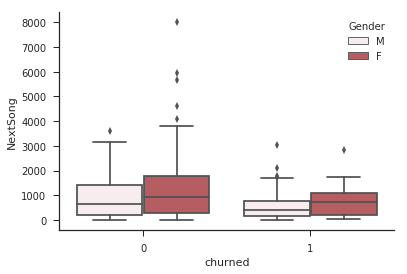

In [22]:
lifetime_pd = churned_dataset.where('page == "NextSong" OR page == "Thumbs Up"').groupby(['userId', 'churned', 'gender', 'page']).count().toPandas()
lifetime_pd = lifetime_pd.pivot_table(index=['userId','churned','gender'], values='count', columns='page').reset_index()
ax = sns.boxplot(data=lifetime_pd, x='churned', y='NextSong', hue='gender',color='r')
plt.legend(title='Gender', loc='best')
sns.despine(ax=ax);

**Customer lifetime songs listened didn\'t vary a lot**

- Customer lifetime stats

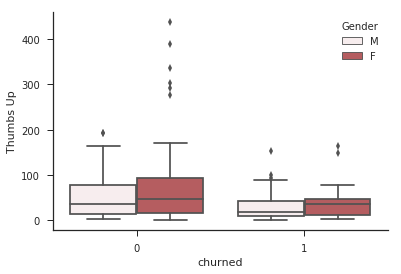

In [23]:
ax = sns.boxplot(data=lifetime_pd, x='churned', y='Thumbs Up', hue='gender',color='r')
plt.legend(title='Gender', loc='best')
sns.despine(ax=ax);

**Customer Thumbs UP songs count liked didn\'t vary a lot also**

- Churn pattern between genders

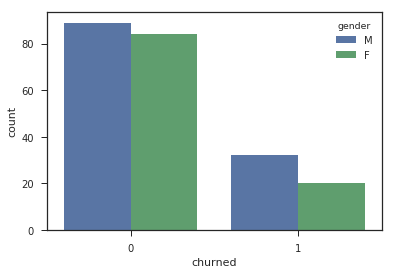

In [24]:
data = churned_dataset.dropDuplicates(["userId", "gender"]).groupby(["churned", "gender"]).count().sort("churned").toPandas()
sns.barplot(x="churned", y="count", hue="gender", data=data);

**Male customers are slightly likely to churn**

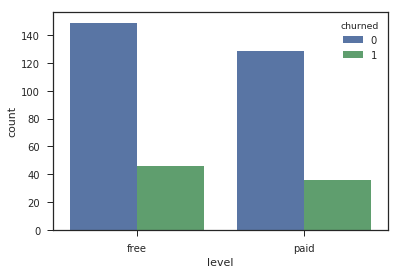

In [25]:
data=churned_dataset.select(['userId', 'level', 'churned']).distinct().groupBy(['churned','level']).count().sort('churned').toPandas()
sns.barplot(x="level", y="count", hue="churned", data=data);

**Churn usually happens when a customer is using a free plan which may feels not commited to continue using the service**

- Songs activity per session

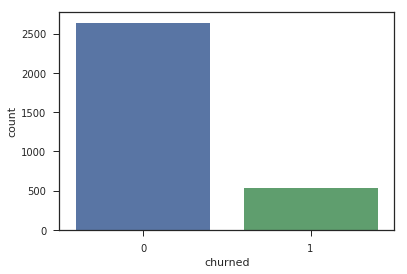

In [26]:
data=churned_dataset.select(['userId', 'sessionId', 'churned']).distinct().groupBy('churned').count().sort('churned').toPandas()
sns.barplot(x="churned", y="count", data=data);

**Loyal users spend more sessions in the service more than users who later**

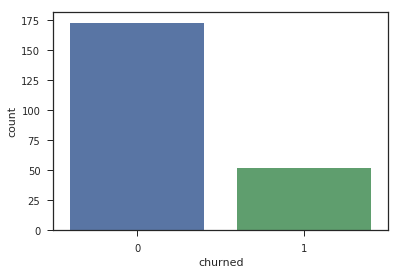

In [27]:
data=churned_dataset.where('page="NextSong"').select(['userId', 'churned']).distinct().groupBy(
    'churned').count().sort('churned').toPandas()
sns.barplot(x="churned", y="count", data=data);

**unchurned users listens to more songs than churned users**

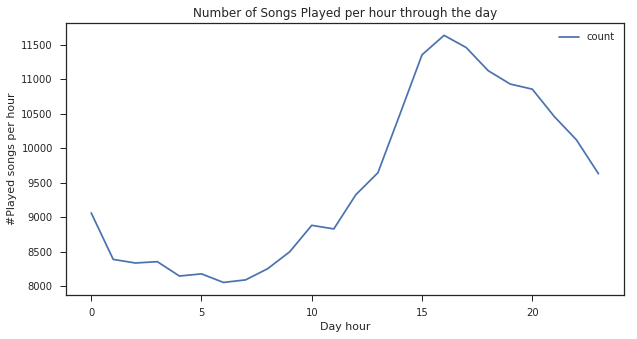

In [28]:
songs_played_hour = churned_dataset.filter("page == 'NextSong'").groupBy("event_hour").count().orderBy(churned_dataset.event_hour.cast("float")).toPandas()
songs_played_hour.plot(kind = "line", figsize= (10,5))
plt.title("Number of Songs Played per hour through the day")
plt.ylabel("#Played songs per hour")
plt.xlabel("Day hour")
plt.show();

**Day hours have a high activity than night hours**

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

- The feature engineering step going to focus on find promising features for model training and the following features will be on eye:
    - Total songs played
    - Total number of days
    - Total Listining
    - Average session songs user
    - Total number of Thumps Up/Down
    - Total songs added to playlist

**- Total Songs Played**   
The more songs the user listened, the more time the user spent with our service, the deeper engagement the user have, leading to less chance to churn.

In [29]:
total_songs_played = churned_dataset.filter("page == 'NextSong'").groupBy("userId").count()
total_songs_played = total_songs_played.withColumnRenamed('count', 'total_songs_played')
total_songs_played.describe().show()

+-------+------------------+------------------+
|summary|            userId|total_songs_played|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|1013.8133333333334|
| stddev|105396.47791907164|1104.9607785540886|
|    min|                10|                 3|
|    max|                99|              8002|
+-------+------------------+------------------+



**- Total number of days**   
the time length since the user registered. It may reflect the user engagement, loyality

In [30]:
total_days = churned_dataset \
    .select('userId','registration','ts') \
    .withColumn('lifetime',(churned_dataset.ts-churned_dataset.registration)) \
    .groupBy('userId') \
    .agg({'lifetime':'max'}) \
    .withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', (col('lifetime')/1000/3600/24).alias('lifetime'))
total_days.describe().show()

+-------+------------------+-------------------+
|summary|            userId|           lifetime|
+-------+------------------+-------------------+
|  count|               225|                225|
|   mean|65391.013333333336|   79.8456834876543|
| stddev|105396.47791907164|  37.66147001861254|
|    min|                10|0.31372685185185184|
|    max|                99|  256.3776736111111|
+-------+------------------+-------------------+



**- Total Listening**

In [31]:
total_listening = churned_dataset.select('userID','length').groupBy('userID').sum().withColumnRenamed('sum(length)', 'listen_time')
total_listening.describe().show()

+-------+------------------+------------------+
|summary|            userID|       listen_time|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|252558.32065155543|
| stddev|105396.47791907164| 275396.4038847635|
|    min|                10|         691.66884|
|    max|                99|1991154.9155799907|
+-------+------------------+------------------+



**- Average session songs per user**

In [32]:
user_session_songs = churned_dataset.where(churned_dataset.page=="NextSong").groupby("userId", "sessionId").count()
avg_session_songs_user_df = user_session_songs.groupby("userId").agg(avg(user_session_songs["count"]).alias("avg_session_songs_user"))
avg_session_songs_user_df.describe().show()

+-------+------------------+----------------------+
|summary|            userId|avg_session_songs_user|
+-------+------------------+----------------------+
|  count|               225|                   225|
|   mean|65391.013333333336|     70.78971233958933|
| stddev|105396.47791907164|      42.6153697543817|
|    min|                10|                   3.0|
|    max|                99|     286.6666666666667|
+-------+------------------+----------------------+



**- Total number of Thumbs Up/Down**   
They may reflect two perspectives, our service quality and user engagement.

In [33]:
thumbup_activity_df = churned_dataset.where(churned_dataset.page=="Thumbs Up").groupby("userId").count()
thumbup_activity_df = thumbup_activity_df.withColumnRenamed('count', 'thumbup_total_number')

In [34]:
thumbdown_activity_df = churned_dataset.where(churned_dataset.page=="Thumbs Down").groupby("userId").count()
thumbdown_activity_df = thumbdown_activity_df.withColumnRenamed('count', 'thumbdown_total_number')

In [35]:
activities = thumbup_activity_df.join(thumbdown_activity_df, on ='userId', how = 'inner')
activities.describe().show()

+-------+------------------+--------------------+----------------------+
|summary|            userId|thumbup_total_number|thumbdown_total_number|
+-------+------------------+--------------------+----------------------+
|  count|               202|                 202|                   202|
|   mean| 65898.11881188118|  61.727722772277225|    12.599009900990099|
| stddev|106344.86643154913|   66.55286398973522|    13.205705046721134|
|    min|                10|                   1|                     1|
|    max|                99|                 437|                    75|
+-------+------------------+--------------------+----------------------+



**- Total songs added to playlist**

In [36]:
playlisted_songs = churned_dataset.select('userID','page').where(
    churned_dataset.page == 'Add to Playlist').groupBy('userID').count().withColumnRenamed('count', 'add_to_playlist')
playlisted_songs.describe().show()

+-------+------------------+-----------------+
|summary|            userID|  add_to_playlist|
+-------+------------------+-----------------+
|  count|               215|              215|
|   mean| 66103.63720930232|30.35348837209302|
| stddev|106360.47999565038| 32.8520568555997|
|    min|                10|                1|
|    max|                99|              240|
+-------+------------------+-----------------+



In [37]:
# Churn label
label = churned_dataset.select('userId', col('churned').alias('label')).dropDuplicates()
label.describe().show()

+-------+------------------+------------------+
|summary|            userId|             label|
+-------+------------------+------------------+
|  count|               225|               225|
|   mean|65391.013333333336|0.2311111111111111|
| stddev|105396.47791907164|0.4224832108996326|
|    min|                10|                 0|
|    max|                99|                 1|
+-------+------------------+------------------+



In [38]:
#joining feature together
processed_data = total_songs_played.join(total_days,'userID','inner') \
    .join(total_listening,'userID','inner') \
    .join(avg_session_songs_user_df,'userID','inner') \
    .join(activities,'userID','inner') \
    .join(playlisted_songs,'userID','inner') \
    .join(label,'userID','inner') \
    .drop('userID') \
    .fillna(0)

processed_data.show(5)

+------------------+------------------+------------------+----------------------+--------------------+----------------------+---------------+-----+
|total_songs_played|          lifetime|       listen_time|avg_session_songs_user|thumbup_total_number|thumbdown_total_number|add_to_playlist|label|
+------------------+------------------+------------------+----------------------+--------------------+----------------------+---------------+-----+
|               275|  55.6436574074074| 66940.89735000003|    39.285714285714285|                  17|                     5|              7|    0|
|               387| 70.07462962962963| 94008.87593999993|                  64.5|                  21|                     6|              8|    0|
|              4079|131.55591435185184|1012312.0927899999|    145.67857142857142|                 171|                    41|            118|    0|
|              2111|19.455844907407407| 523275.8428000004|                 211.1|                 100|          

In [39]:
processed_data.printSchema()

root
 |-- total_songs_played: long (nullable = false)
 |-- lifetime: double (nullable = false)
 |-- listen_time: double (nullable = false)
 |-- avg_session_songs_user: double (nullable = false)
 |-- thumbup_total_number: long (nullable = false)
 |-- thumbdown_total_number: long (nullable = false)
 |-- add_to_playlist: long (nullable = false)
 |-- label: integer (nullable = false)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

- The modeling phase will with following steps:
    - Data preprocessing like vectorizing and scaling
    - train model using training dataset
    - tune model using validation dataset
    - test best model selected based on validation dataset on test dataset.

### Preprocessing data

In [40]:
# vectorizing features
cols = ["total_songs_played","lifetime", "listen_time", "avg_session_songs_user",
        'thumbup_total_number','thumbdown_total_number','add_to_playlist']
assembler = VectorAssembler(inputCols=cols, outputCol="NumFeatures")
vectorized_data = assembler.transform(processed_data)

Standardizing the features by taking off the mean and divided by the standard deviation of each feature.

In [41]:
# standard scaler
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withStd=True)
scalerModel = scaler.fit(vectorized_data)
data = scalerModel.transform(vectorized_data)

Splitting data into train, validation, and test sets to be 60%, 20%, 20% as follow

In [42]:
# train test split
train, rest = data.randomSplit([0.6, 0.4], seed=42)
validation, test = rest.randomSplit([0.5, 0.5], seed=42)

### Training
- The training phase focuses passing training data by cross validation to some classifier like:
    - Logistic Regression
    - Random Forest
    - Decision Tree
    - Gradient Boosted Trees 

#### Logistic Regression

In [48]:
print("Training the Logistic Regression Model...")
start_time = time()
lr = LogisticRegression()
# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
# build paramGrid
paramGrid = ParamGridBuilder().build()
#set cross validation
crossval_lr = CrossValidator(estimator=lr,estimatorParamMaps=paramGrid,evaluator=f1_evaluator,numFolds=5)
#fitting the model
lr_model = crossval_lr.fit(train)        
training_time = (time() - start_time)
print("That took %s Seconds" % (time() - start_time))

Training the Logistic Regression Model...
That took 1052.871725320816 Seconds


In [49]:
results_lr = lr_model.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('F-1 Score:{}'.format(evaluator.evaluate(results_lr, {evaluator.metricName: "f1"})))

F-1 Score:0.5606060606060606


#### Random Forest

In [53]:
print("Training the Random Forest Model...")
start_time = time()
# initialize classifier
rf = RandomForestClassifier()
# build paramGrid
paramGrid = ParamGridBuilder().build()
# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
crossval_rf = CrossValidator(estimator=rf,estimatorParamMaps=paramGrid,evaluator=f1_evaluator,numFolds=5)
#fitting the model
rf_model = crossval_rf.fit(train)        
training_time = (time() - start_time)
print("That took %s Seconds" % (time() - start_time))

Training the Random Forest Model...
That took 416.1676433086395 Seconds


In [54]:
results_rf = rf_model.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('F-1 Score:{}'.format(evaluator.evaluate(results_rf, {evaluator.metricName: "f1"})))

F-1 Score:0.5606060606060606


#### DecisionTree Machine

In [43]:
print("Training the DecisionTree Model...")
start_time = time()
# initialize classifier
dt = DecisionTreeClassifier()
# build paramGrid
paramGrid = ParamGridBuilder().build()
# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
crossval_dt = CrossValidator(estimator=dt,estimatorParamMaps=paramGrid,evaluator=f1_evaluator,numFolds=5)
#fitting the model
dt_model = crossval_dt.fit(train)        
training_time = (time() - start_time)
print("That took %s Seconds" % (time() - start_time))

Training the DecisionTree Model...
That took 381.37851881980896 Seconds


In [44]:
results_dt = dt_model.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('F-1 Score:{}'.format(evaluator.evaluate(results_dt, {evaluator.metricName: "f1"})))

F-1 Score:0.8084415584415583


#### Gradient Boosted Trees

In [42]:
print("Training the GBT Model...")
start_time = time()
# initialize classifier
gbt = GBTClassifier()
# build paramGrid
paramGrid = ParamGridBuilder().build()
# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
crossval_gbt = CrossValidator(estimator=gbt,estimatorParamMaps=paramGrid,evaluator=f1_evaluator,numFolds=5)
#fitting the model
gbt_model = crossval_gbt.fit(train)        
training_time = (time() - start_time)
print("That took %s Seconds" % (time() - start_time))

Training the GBT Model...
That took 1978.1320247650146 Seconds


In [43]:
results_gbt = gbt_model.transform(validation)
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('F-1 Score:{}'.format(evaluator.evaluate(results_gbt, {evaluator.metricName: "f1"})))

F-1 Score:0.9075369075369075


#### Model summary:
- Results:
    - The ```LogisticRegression``` model got F1 score of:0.56, in 1052 seconds.
    - The ```RandomForestClassifier``` model got F1 score of: 0.56, in 416 seconds.
    - The ```DecisionTreeClassifier``` model got F1 score of: 0.81, in 381 seconds.
    - The ```GBTClassifier``` model got F1 score of: 0.90, in 2065 seconds. 
- Based on above resluts we can assuem the models with **0.56** F1 score as **baseline models** and start to improve from it. 
- Although we do care about time resources, but since the data size is still reletively small, and the performance difference is huge, we will prefer the model that perform the best. Therefore, we choose **GBT** model as our final used model and conduct a grid search to fine tune our model this time.


#### Model Refinement
In this step we going to use grid search and works on investigating ```maxDepth``` and ```maxIter``` features on GBT model with same number of folds and evaluate them with F1 score metric also

In [59]:
# build paramGrid
paramGrid_gbt = ParamGridBuilder().addGrid(
    gbt.maxDepth,[5, 10]).addGrid(
    gbt.maxIter, [10,20]).build()

# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

crossval_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid_gbt,
                          evaluator=f1_evaluator,
                          numFolds=5)
model = crossval_gbt.fit(train)
model.avgMetrics

[0.7801330133748134, 0.77409765983946, 0.7824388496037553, 0.7824388496037553]

#### Model Selection and Evaluation

##### Best Model

In [43]:
gbt_best = GBTClassifier(maxIter=20,maxDepth=5)
gbt_best_model = gbt_best.fit(train)
results_final = gbt_best_model.transform(test) #predict with test data

#### Evaluation with test data

In [44]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print('Test set results:')
print('F-1 Score:{}'.format(evaluator.evaluate(results_final, {evaluator.metricName: "f1"})))

Test set results:
F-1 Score:0.7004800307219663


Exploring the features importance

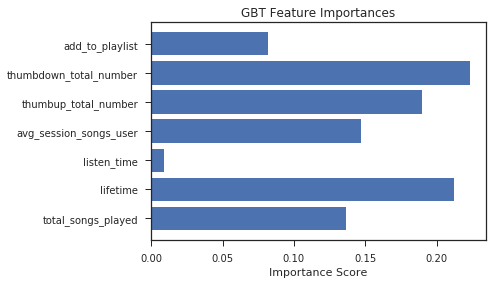

In [45]:
features_importance = gbt_best_model.featureImportances.values
y_pos = np.arange(len(cols))

plt.barh(y_pos, features_importance, align='center')
plt.yticks(y_pos, cols)
plt.xlabel('Importance Score')
plt.title('GBT Feature Importances');

- From the graph above we can easily observe these features as the most important features which can decide the future expected behavior from the user in next time:
    - Total number of liked/unliked songs
    - Account life time
    - Number of played songs whatever in a single session or generaly   
    
    
That appeared in top features overall.


## Conclusion

#### Reflection
- This project built to use spark lib but may still have a problem in running models that take some time and can't be run on local machine and in the environment takes a lot specially if you trying to grid search some parameters, and meke me ask what if we worked on all data not just small subset.
- I liked some difficulties in this project like features exploration and engineering and finding some way to get a pattern users follow before stop using service.

#### Improvement
The features can be improved a lot after considering more factors, adding mre features, but we can use more data to have better results as the user base grow.

Currently, we have a portion of unique users, and we only use 60% of them to train. That said, the model has a huge potential to improve if the sample size increase, and the expected performance will also increase.